In [374]:
import numpy as np
from scipy.stats import uniform, norm, f, t
import statistics
from scipy import linalg
from sklearn.linear_model import LinearRegression
import random
from sklearn.model_selection import cross_validate

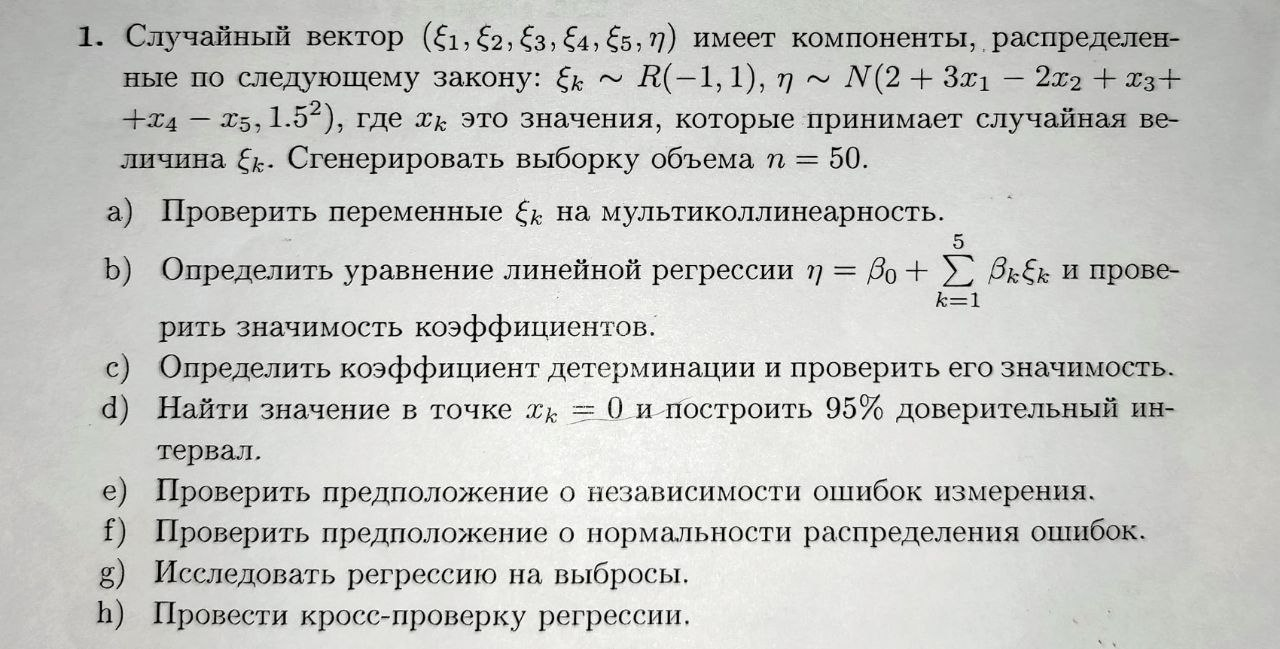

In [375]:
N = 50
x = np.zeros((6,50))
a = np.zeros(50)
for i in range(5):
    x[i,:] = uniform.rvs(loc=-1, scale=2, size = 50)
for j in range(50):
    a[j] = 2 + 3*x[0,j] - 2*x[1,j] + x[2,j] + x[3,j] - x[4,j]
    x[5,j] = norm.rvs(a[j], 1.5)

## a)

In [376]:
x_ksi = x[:5,:]
R_sq = np.zeros(5)
for i in range(5):
    y = x_ksi[i, :]
    TSS = np.sum(np.square(y - np.mean(y)))
    
    psi = np.ones((50,5))
    psi[:,1:] = np.delete(x_ksi,i,0).T
    F_inv = np.linalg.inv(psi.T@psi)
    beta = F_inv@psi.T@y
    RSS = (y - psi@beta).T @ (y - psi@beta)
    
    R_sq[i] = 1 - RSS/TSS
R_sq

array([0.06020369, 0.04373364, 0.06189872, 0.07415865, 0.0413922 ])

=> ξ не являются мультиколлинеарными

## b)

In [377]:
# "вручную" (β[0] - у нас последний коэффициент)
target_eta = np.array([x[5,0], x[5,12], x[5,19], x[5,25], x[5,38], x[5,49]])
target_ksi = np.ones((6,6))
for i in range(5):
    target_ksi[i, :] = np.array([x[i,0], x[i,12], x[5,19], x[i,25], x[i,38], x[i,49]])
betas_hand = linalg.solve(target_ksi, target_eta)
betas_hand

array([ 9.14456985, -4.22675216,  1.25264035,  2.6953582 ,  5.57271546,
       -9.97505109])

In [378]:
# с помощью встроенной библиотеки для линейной регресси, без нулевого веса
x_reg = x[:5,:].T
y_reg = x[5,:]
reg = LinearRegression().fit(x_reg, y_reg)
betas = reg.coef_
betas

array([ 3.0016401 , -2.01959654,  0.41403971,  0.97944399, -1.11168608])

In [379]:
# проверяем значимость бутстрапом (можно было не бутстрапом, а через t(N-6))
delta_boot = np.zeros((1000,5))
y = np.zeros((6,50))
for i in range(1000):
    y[0, :] = np.array(random.sample((x[0,:]).tolist(), N, counts = [100 for i in range(N)])) #хотим двумерную подвыборку или два цикла
    for m in range(50):
        for k in range(50):
            if x[0, k] == y[0, m]:
                y[:, m] = x[:, k]
                break
        
    x_boot = y[:5,:].T
    y_boot = y[5,:]
    reg_boot = LinearRegression().fit(x_boot, y_boot)
    betas_boot = reg_boot.coef_
    delta_boot[i, :] = np.abs(betas_boot - betas)

In [380]:
for i in range(5):
    m = sum(np.sort(delta_boot[:, i])>=abs(betas[i]))
    p_value = m/1000
    print(p_value)
    if p_value > 0.05:
        print('нет оснований отвергнуть гипотезу о незначимости коэффициента beta', i+1, sep='')
    else:
        print('отвергаем гипотезу о незначимости коэффициента beta', i+1, sep='')

0.0
отвергаем гипотезу о незначимости коэффициента beta1
0.0
отвергаем гипотезу о незначимости коэффициента beta2
0.341
нет оснований отвергнуть гипотезу о незначимости коэффициента beta3
0.004
отвергаем гипотезу о незначимости коэффициента beta4
0.006
отвергаем гипотезу о незначимости коэффициента beta5


In [381]:
# сделаем не через бутстрап
for i in range(5):
    deltas = betas[i]/np.sqrt(RSS*F_inv[i,i])*(N-6)**0.5
    p_values = 2*(1 - t.cdf(abs(deltas), N-6))
    print(p_values)
    if p_values > 0.05:
        print('нет оснований отвергнуть гипотезу о незначимости коэффициента beta', i+1, sep='')
    else:
        print('отвергаем гипотезу о незначимости коэффициента beta', i+1, sep='')

0.0
отвергаем гипотезу о незначимости коэффициента beta1
0.0
отвергаем гипотезу о незначимости коэффициента beta2
0.01058393872496799
отвергаем гипотезу о незначимости коэффициента beta3
4.954756804842475e-08
отвергаем гипотезу о незначимости коэффициента beta4
3.4819036542899084e-11
отвергаем гипотезу о незначимости коэффициента beta5


## c)

In [382]:
y = x[5, :]
TSS = np.sum(np.square(y - np.mean(y)))
    
psi = np.ones((50,6))
psi[:,1:] = np.delete(x,5,0).T
F_inv = np.linalg.inv(psi.T@psi)
beta = F_inv@psi.T@y
RSS = (y - psi@beta).T @ (y - psi@beta)
    
R_eta = 1 - RSS/TSS

print('коэффициент детерминации: ', R_eta, sep='')

коэффициент детерминации: 0.7632820952754487


In [383]:
delta_est = R_eta**2/(1-R_eta**2) * (N - 6)/(6-1)
delta_est

12.28287172883287

Δ ~ F(6-1,50-1) = F(5,49)

In [384]:
p_value = 1 - f.cdf(np.abs(delta_est), 6-1, N-1)
p_value

9.68792258637663e-08

=> отвергаем гипотезу о незначимости коэффициента детерминации

## d)

In [385]:
a_0 = 2
eta_0 = norm.rvs(a_0, 1.5)
print ('рандомное значение в нуле: ', eta_0, sep='')

рандомное значение в нуле: 1.5334388693099312


In [386]:
# построим численный доверительный интервал
delta_int = np.zeros(1000)
for i in range(1000):
    eta_boot = norm.rvs(a_0, 1.5)
    delta_int[i] = eta_boot - eta_0
print('доверительный интервал: (', np.sort(delta_int)[24], ', ', np.sort(delta_int)[974], ')', sep='')

доверительный интервал: (-2.3251689348415256, 3.3631129880333344)


## e)

In [387]:
y = x[5,:]
e = np.zeros(50)
psi = np.ones((50,6))
psi[:,1:] = np.delete(x,5,0).T
F_inv = np.linalg.inv(psi.T@psi)
beta = F_inv@psi.T@y
e = y - psi@beta
e

array([ 1.42618723, -0.09864843, -0.92988907, -0.77338957, -0.28793653,
       -1.06149593,  1.22444936,  1.255912  ,  2.13435119, -2.71836518,
        0.18416061,  1.46418106, -0.29952083,  0.33217011, -0.38237308,
        2.79630151,  2.03665832, -1.14173925, -1.75903452, -0.74703051,
       -2.41163731, -2.02139792, -1.28373003,  0.02828332,  0.32913479,
       -0.24947416,  2.39641787, -0.9672697 ,  1.4732179 ,  0.7315929 ,
       -0.08458997,  0.40971624,  0.22507114,  1.10769542, -0.15222528,
        1.00268641,  0.32424888,  1.47363891, -0.43828041, -1.97914306,
        0.94453579,  1.31089403, -2.49670846, -1.81327672, -0.29154452,
       -0.09885142, -0.34470316, -1.36577667,  1.48901227,  0.09751445])

In [388]:
I=0
for i in range(N):
    for j in range (i+1, N):
        if(e[i] > e[j]):
            I += 1
I

621

Δ ~> N(0,1)

In [389]:
delta_est = (I - N*(N-1)/4)/(N**3/36)**0.5
p_value = 2*(1 - norm.cdf(abs(delta_est)))
p_value

0.8853032305473783

=> нет оснований отвергнуть гипотезу о независимости ошибок измерения

## g)

In [390]:
eps = np.zeros(50)
eps = x[5,:] - reg.predict(x_reg)

In [391]:
sigma = np.median(np.abs(eps))/0.675
sigma

1.459226749072672

In [392]:
quantity = 0
for i in range(50):
    if eps[i]<=-2*sigma or eps[i]>=2*sigma:
        quantity+=1
        print(i, ' является выбросом: eta = ', eps[i], sep='')
if quantity == 0:
    print('выбросов нет!')

выбросов нет!


## f)

In [393]:
#Колмогоров

def F_est(x):
    F = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        F[i] = np.argsort(x)[i]/x.shape[0]
    return F

In [394]:
teta2_est = (np.sum(np.square(eps))/N)**0.5
print('оценка дисперсии: ', teta2_est, sep = '')

оценка дисперсии: 1.3083967075641902


In [397]:
delta_eps = N**0.5 * np.max(np.abs(F_est(eps) - norm.cdf(np.sort(eps), 0, teta2_est)))
delta_eps

0.4866443878611028

In [398]:
delta_boot = np.zeros(10000)
for i in range(10000):
    y = np.array(random.sample((eps).tolist(), N, counts = [100 for i in range(N)]))
    teta2_boot = (np.sum(np.square(y))/N)**0.5
    F = norm(0, teta2_boot)
    delta_boot[i] = N**0.5 * np.max(abs(F_est(eps) - F.cdf(eps)))
k = sum(delta_boot < delta_eps)+1
p_value = 1 - (k-1)/10000
p_value

0.9318

=> нет оснований отвергнуть гипотезу о нормальности распределения ошибок

## h)

In [399]:
cv = np.zeros(50)
for i in range(50):
    x_test = x[:5,i].reshape((5,1)).T
    y_test = x[5,i]
    x_train = np.delete(x[:5,:].T, i, 0)
    y_train = np.delete(x[5,:], i)
    reg_cv = LinearRegression().fit(x_train, y_train)
    cv[i] = (reg_cv.predict(x_test) - y_test)**2
cv

array([2.72590622e+00, 1.16763212e-02, 1.17344966e+00, 7.51857718e-01,
       9.34186449e-02, 1.63974541e+00, 2.37497407e+00, 1.76134615e+00,
       6.12848225e+00, 9.95060706e+00, 4.13058081e-02, 2.37753206e+00,
       1.14691838e-01, 1.48687257e-01, 1.55378907e-01, 9.51657109e+00,
       5.14276336e+00, 1.73415205e+00, 4.67666312e+00, 7.09003339e-01,
       9.35670192e+00, 6.07314505e+00, 2.03554244e+00, 1.07661911e-03,
       1.50704315e-01, 8.58936027e-02, 9.02393164e+00, 1.09264629e+00,
       3.13762938e+00, 6.41908793e-01, 8.73288183e-03, 1.95091224e-01,
       6.35613407e-02, 1.51112427e+00, 2.84868627e-02, 1.26433515e+00,
       1.26898836e-01, 2.39441426e+00, 2.25408120e-01, 5.20290311e+00,
       1.45982990e+00, 3.23851093e+00, 7.69514094e+00, 4.17626007e+00,
       1.06017439e-01, 1.13968364e-02, 1.85730142e-01, 2.45297361e+00,
       2.46674306e+00, 1.06819872e-02])

In [400]:
CVSS = np.sum(cv)
TSS = np.sum(np.square(x[5,:] - np.mean(x[5,:])))
R_cv = 1 - CVSS/TSS
R_cv

0.6801591070303761

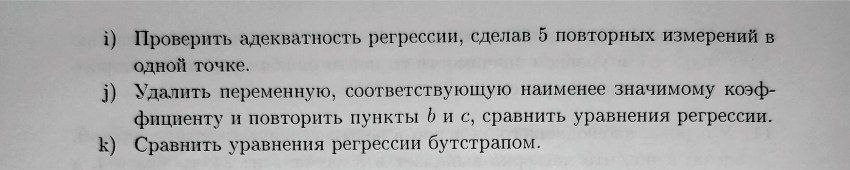

## i)

In [401]:
# пусть все ξ = 0.5
RSS = (x[5,:] - psi@beta).T @ (x[5,:] - psi@beta)
b = 2 + 0.5*(3-2+1+1-1)
eta_ad = np.zeros(5)
for i in range(5):
    eta_ad[i] = norm.rvs(b, 1.5)
sigma_cap = 1/4*np.sum(np.square(eta_ad - np.mean(eta_ad)))
delta_est = RSS/((N-6)*sigma_cap)
delta_est

0.8735863546804394

In [402]:
p_value = 1 - f.cdf(np.abs(delta_est), N-6, 4)
p_value

0.6518429942135514

=> нет оснований отвергнуть гипотезу об адекватности модели

## j)

In [408]:
x_simpl = np.delete(x,2,0)

#b)
x_reg = x_simpl[:4,:].T
y_reg = x_simpl[4,:]
reg = LinearRegression().fit(x_reg, y_reg)
betas = reg.coef_

delta_boot = np.zeros((1000,4))
y = np.zeros((5,50))
for i in range(1000):
    y[0, :] = np.array(random.sample((x_simpl[0,:]).tolist(), N, counts = [100 for i in range(N)])) #хотим двумерную подвыборку или два цикла
    for m in range(50):
        for k in range(50):
            if x_simpl[0, k] == y[0, m]:
                y[:, m] = x_simpl[:, k]
                break
        
    x_boot = y[:4,:].T
    y_boot = y[4,:]
    reg_boot = LinearRegression().fit(x_boot, y_boot)
    betas_boot = reg_boot.coef_
    delta_boot[i, :] = np.abs(betas_boot - betas)

for i in range(4):
    m = sum(np.sort(delta_boot[:, i])>=abs(betas[i]))
    p_value = m/1000
    print(p_value)
    if p_value > 0.05:
        print('нет оснований отвергнуть гипотезу о незначимости коэффициента beta', i+1, sep='')
    else:
        print('отвергаем гипотезу о незначимости коэффициента beta', i+1, sep='')

0.0
отвергаем гипотезу о незначимости коэффициента beta1
0.0
отвергаем гипотезу о незначимости коэффициента beta2
0.002
отвергаем гипотезу о незначимости коэффициента beta3
0.001
отвергаем гипотезу о незначимости коэффициента beta4


In [409]:
#c)
TSS = np.sum(np.square(x_simpl[4] - np.mean(x_simpl[4])))
    
psi = np.ones((50,5))
psi[:,1:] = np.delete(x_simpl,4,0).T
F_inv = np.linalg.inv(psi.T@psi)
beta = F_inv@psi.T@x_simpl[4]
RSS1 = (x_simpl[4] - psi@beta).T @ (x_simpl[4] - psi@beta)
    
R_sqrt = 1 - RSS1/TSS

delta_est = R_sqrt**2/(1-R_sqrt**2) * (N - 5)/(5-1)
p_value = 1 - f.cdf(np.abs(delta_est), 5-1, N-1)
print('коэффициент детерминации: ', R_sqrt, sep='')
print('p_value: ', p_value, sep='')

коэффициент детерминации: 0.7568040238162252
p_value: 4.1983818088731084e-08


=> отвергаем гипотезу о незначимости коэффициента детерминации

In [410]:
betas

array([ 3.03989042, -2.02733445,  1.02490871, -1.18037513])

In [411]:
delta = (RSS1 - RSS)/RSS * (N-6)
p_value = 1 - f.cdf(delta,N-6,1)
p_value

0.6329022789477109

=> нет оснований отвергнуть гипотезу о том, что усложнение модели не является значимым

## k)

In [412]:
delta_boot = np.zeros(1000)
y = np.zeros((5,50))
for i in range(1000):
    y[0, :] = np.array(random.sample((x_simpl[0,:]).tolist(), N, counts = [100 for i in range(N)])) #хотим двумерную подвыборку или два цикла
    for m in range(50):
        for k in range(50):
            if x_simpl[0, k] == y[0, m]:
                y[:, m] = x_simpl[:, k]
                break
        
    TSS = np.sum(np.square(y[4] - np.mean(y[4])))
    
    psi = np.ones((50,5))
    psi[:,1:] = np.delete(y,4,0).T
    F_inv = np.linalg.inv(psi.T@psi)
    beta = F_inv@psi.T@y[4]
    RSS1 = (y[4] - psi@beta).T @ (y[4] - psi@beta)

    R_boot = 1 - RSS1/TSS
    delta_boot[i] = R_eta - R_boot

delta_est = R_eta - R_sqrt
m = sum(delta_boot >= delta_est)
p_value = m/1000
p_value

0.339

=> нет оснований отвергнуть гипотезу о том, что усложнение модели не является значимым